# loading important libraries & packages

In [57]:
import nltk
import seaborn as sns
import pandas as pd
import pickle
import numpy as np

from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

In [58]:
# Download NLTK resources (run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pardhasaradhichukka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pardhasaradhichukka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pardhasaradhichukka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Intial Data Analysis

In [59]:
job_df = pd.read_csv('aa_jobs.csv')
job_df.head(3)

,query,company,title,description,location,place,remote,type,createdAt,date,insights,jobId,link
0,Business development executive,Aditya Birla Capital,Business Development Manager (BDM) - Aditya Bi...,This job is provided by apna.co Agency Channel...,India,"Pune, Maharashtra, India",on site,full time,2024-03-05T14:53:14.243Z,2024-03-04,[],3846385519,https://in.linkedin.com/jobs/view/business-dev...
1,Business development executive,Pidilite Industries Limited,Area Business Development Executive,Key Requirement for the Position\n\nJob Descri...,India,"Hyderabad, Telangana, India",on site,full time,2024-03-05T14:53:16.892Z,2024-03-05,[],3829070933,https://in.linkedin.com/jobs/view/area-busines...
2,Influencer marketing,Maharishi Ayurveda,Social Media Manager,Combines marketing and social media management...,India,"Noida, Uttar Pradesh, India",on site,full time,2024-03-05T14:54:15.132Z,2024-03-05,[],3846245582,https://in.linkedin.com/jobs/view/social-media...


In [60]:
job_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8396 entries, 0 to 8395
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   query        8396 non-null   object
 1   company      8396 non-null   object
 2   title        8396 non-null   object
 3   description  8396 non-null   object
 4   location     8396 non-null   object
 5   place        8396 non-null   object
 6   remote       8396 non-null   object
 7   type         8396 non-null   object
 8   createdAt    8396 non-null   object
 9   date         8396 non-null   object
 10  insights     8396 non-null   object
 11  jobId        8396 non-null   int64 
 12  link         8396 non-null   object
dtypes: int64(1), object(12)
memory usage: 852.8+ KB


In [61]:
column_names = job_df.columns
column_names

Index(['query', 'company', 'title', 'description', 'location', 'place',
       'remote', 'type', 'createdAt', 'date', 'insights', 'jobId', 'link'],
      dtype='object')

In [62]:
print(job_df.isnull().sum())

query          0
company        0
title          0
description    0
location       0
place          0
remote         0
type           0
createdAt      0
date           0
insights       0
jobId          0
link           0
dtype: int64


### interesting to find that there are no null values in the dataset.

In [63]:
print("Date Range:", job_df['date'].min(), "to", job_df['date'].max())
print('----------------------------------')
print('list of unique queries')
print(job_df['query'].unique())

Date Range: 2024-03-04 to 2024-03-14
----------------------------------
list of unique queries
['Business development executive' 'Influencer marketing' 'sales lead'
 'Product Marketing' 'Digital Marketing' 'Chief Technology Officer']


In [64]:
num_jobs_per_type = job_df['type'].value_counts()
num_jobs_per_type

full time     6090
internship    1116
contract       742
part time      353
other           73
temporary       17
volunteer        5
Name: type, dtype: int64

### After seeing the results, one things can be noticed that after building this "job recommendation engine" user who are trying to find either full-time or interships jobs can benifit the most when compared to other job types

In [65]:
job_df['place'].value_counts()

Bengaluru, Karnataka, India      1402
India                            1134
Mumbai Metropolitan Region        548
Hyderabad, Telangana, India       448
Mumbai, Maharashtra, India        436
                                 ... 
Janakpuri, Delhi, India             1
Palamu, Jharkhand, India            1
Gurgaon Rural, Haryana, India       1
Jhunjhunu, Rajasthan, India         1
Ujjain, Madhya Pradesh, India       1
Name: place, Length: 318, dtype: int64

### so from the above results, we can extract the state names from the "place" column which later can be used for recommendation engine

# Feaure Engineering

In [66]:
def extract_state(place):
    parts = place.split(',')
    if len(parts) == 3:  # city, state, country
        return parts[1].strip()
    elif len(parts) == 2:  # state, country or state
        return parts[0].strip()
    else:
        return place.strip()  # No comma, just state

# Apply the extraction function to create the "state" column
job_df['state'] = job_df['place'].apply(extract_state)

# Print the updated DataFrame
job_df.head(3)

,query,company,title,description,location,place,remote,type,createdAt,date,insights,jobId,link,state
0,Business development executive,Aditya Birla Capital,Business Development Manager (BDM) - Aditya Bi...,This job is provided by apna.co Agency Channel...,India,"Pune, Maharashtra, India",on site,full time,2024-03-05T14:53:14.243Z,2024-03-04,[],3846385519,https://in.linkedin.com/jobs/view/business-dev...,Maharashtra
1,Business development executive,Pidilite Industries Limited,Area Business Development Executive,Key Requirement for the Position\n\nJob Descri...,India,"Hyderabad, Telangana, India",on site,full time,2024-03-05T14:53:16.892Z,2024-03-05,[],3829070933,https://in.linkedin.com/jobs/view/area-busines...,Telangana
2,Influencer marketing,Maharishi Ayurveda,Social Media Manager,Combines marketing and social media management...,India,"Noida, Uttar Pradesh, India",on site,full time,2024-03-05T14:54:15.132Z,2024-03-05,[],3846245582,https://in.linkedin.com/jobs/view/social-media...,Uttar Pradesh


In [67]:
job_df['state'].value_counts()

Karnataka                      1593
India                          1134
Maharashtra                    1112
Haryana                         664
Delhi                           559
Mumbai Metropolitan Region      548
Uttar Pradesh                   486
Telangana                       462
Tamil Nadu                      427
Gujarat                         304
Greater Kolkata Area            157
Rajasthan                       140
Kerala                          119
Madhya Pradesh                  104
West Bengal                      60
Punjab                           60
Chandigarh                       59
Greater Bengaluru Area           50
Odisha                           47
Greater Delhi Area               33
Uttarakhand                      30
Goa                              29
Andhra Pradesh                   24
Chhattisgarh                     23
Jharkhand                        21
Bihar                            15
Mohali district                  15
Pune/Pimpri-Chinchwad Area  

In [68]:
top_15_states = job_df['state'].value_counts().nlargest(15)
top_15_states

Karnataka                     1593
India                         1134
Maharashtra                   1112
Haryana                        664
Delhi                          559
Mumbai Metropolitan Region     548
Uttar Pradesh                  486
Telangana                      462
Tamil Nadu                     427
Gujarat                        304
Greater Kolkata Area           157
Rajasthan                      140
Kerala                         119
Madhya Pradesh                 104
West Bengal                     60
Name: state, dtype: int64

### states like Karnataka, Maharashtra, Haryana, Delhi, UP etc.,. so if the job seekers aim to go with these states they can find ample number of job openings

# Visulaisation

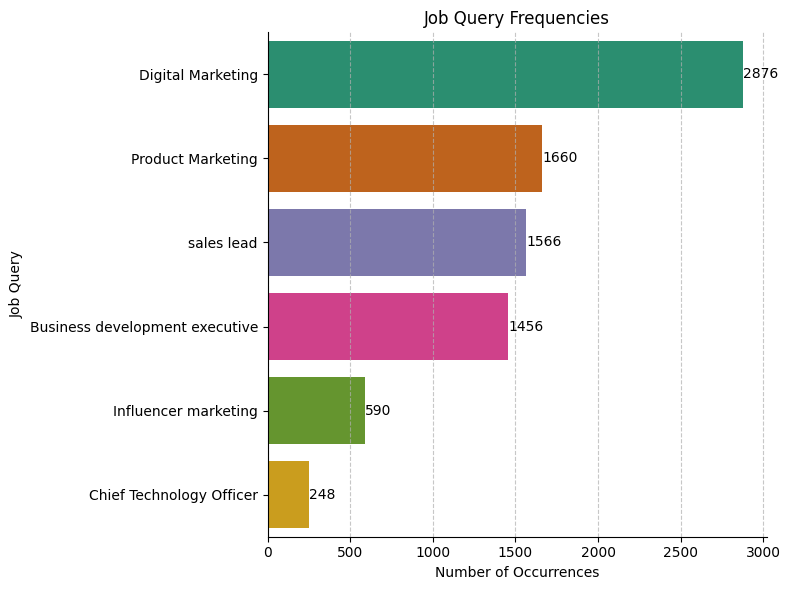

In [69]:
query_counts = job_df['query'].value_counts()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=query_counts.values, y=query_counts.index, palette='Dark2')

# Add count values inside the bars
for i, v in enumerate(query_counts.values):
    ax.text(v + 0.2, i, str(v), color='black', va='center')

plt.title("Job Query Frequencies")
plt.xlabel("Number of Occurrences")
plt.ylabel("Job Query")
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.gca().spines[['top', 'right']].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

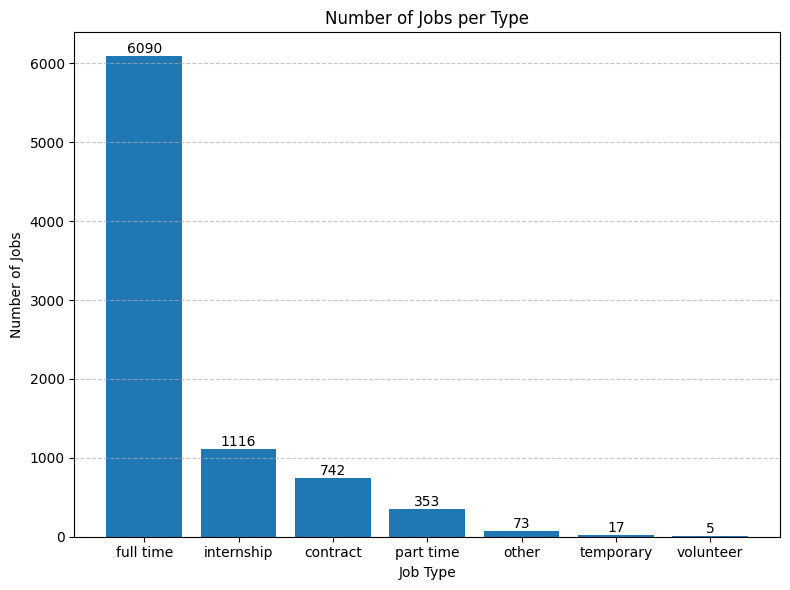

In [70]:
num_jobs_per_type = job_df['type'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
bars = plt.bar(num_jobs_per_type.index, num_jobs_per_type.values)

# Add count values on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             str(int(bar.get_height())), ha='center', va='bottom', fontsize=10)

# Customize the plot
plt.xlabel('Job Type')
plt.ylabel('Number of Jobs')
plt.title('Number of Jobs per Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

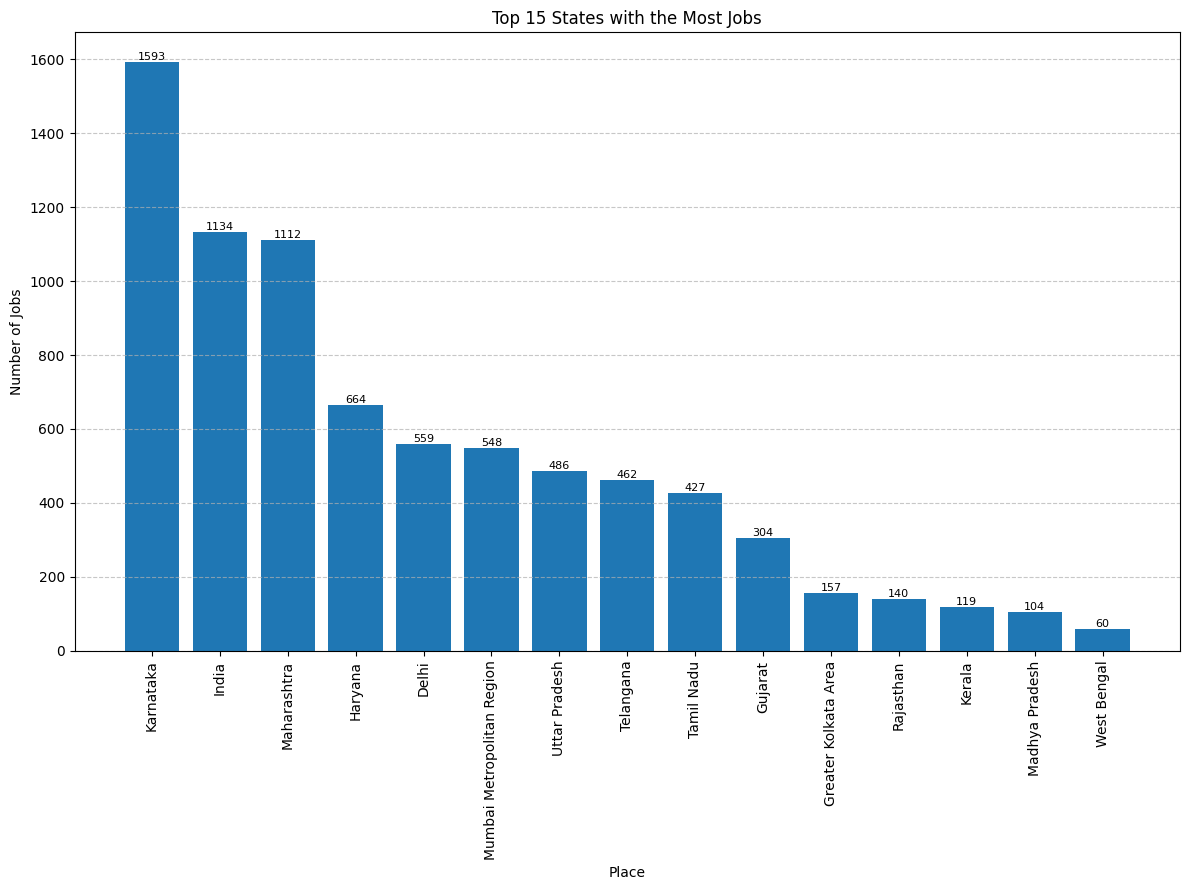

In [71]:
top_15_states = job_df['state'].value_counts().head(15)

# Create a bar chart
plt.figure(figsize=(12, 9))
bars = plt.bar(top_15_states.index, top_15_states.values)

# Add count values on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             str(int(bar.get_height())), ha='center', va='bottom', fontsize=8)

# Customize the plot
plt.xlabel('Place')
plt.ylabel('Number of Jobs')
plt.title('Top 15 States with the Most Jobs')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

# using NLP techniques to find most common words in title & description columns 

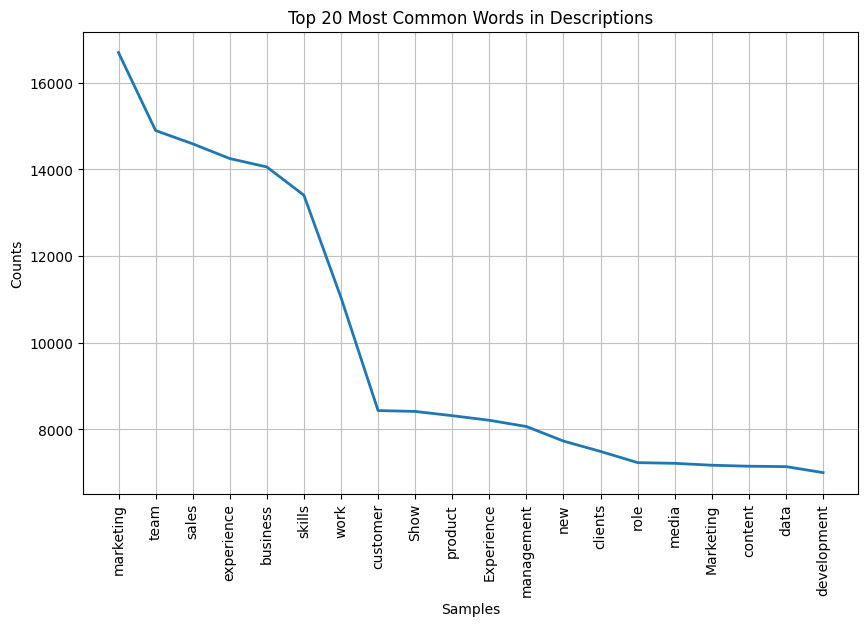

In [72]:
# Tokenize text and remove stopwords
def process_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]
    return filtered_tokens

# Concatenate all descriptions into a single string
all_descriptions = ' '.join(job_df['description'])

# Process text and get frequency distribution
tokens = process_text(all_descriptions)
fdist = FreqDist(tokens)

# Plot the most common words
plt.figure(figsize=(10, 6))
fdist.plot(20, title='Top 20 Most Common Words in Descriptions')
plt.show()

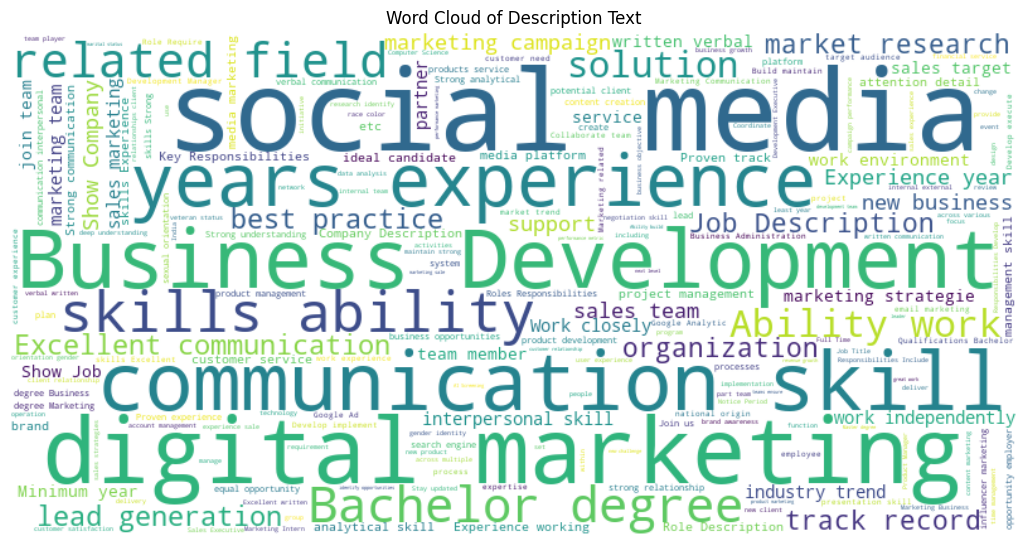

In [73]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
plt.figure(figsize=(13, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Description Text')
plt.show()

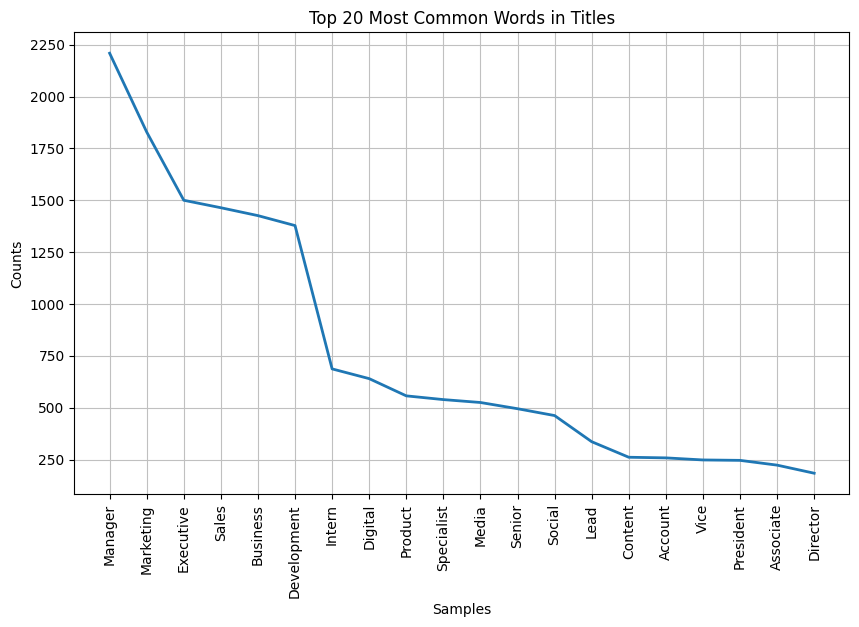

In [74]:
# Tokenize text and remove stopwords for titles
all_titles = ' '.join(job_df['title'])
title_tokens = process_text(all_titles)

# Get frequency distribution of title tokens
title_fdist = FreqDist(title_tokens)

# Plot the most common words in titles
plt.figure(figsize=(10, 6))
title_fdist.plot(20, title='Top 20 Most Common Words in Titles')
plt.show()

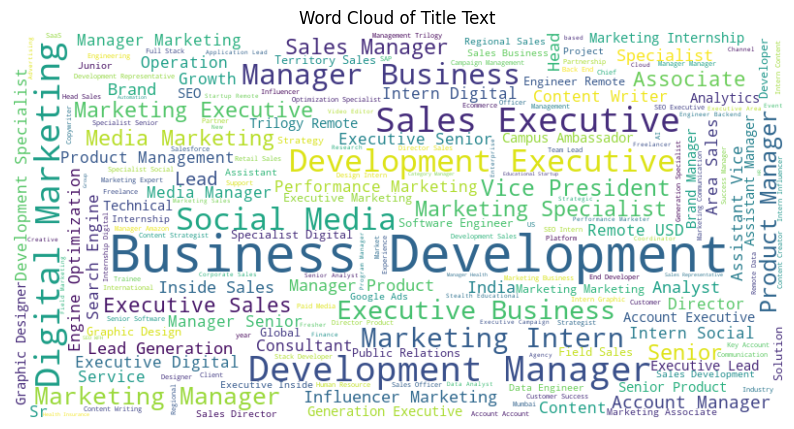

In [75]:
# Generate word cloud for titles
title_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(title_tokens))
plt.figure(figsize=(10, 6))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Title Text')
plt.show()

# removing unwanted things from title, description & state coulumn

In [76]:
# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Define function for text preprocessing
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize words (optional)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Combine tokens into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Apply text preprocessing to selected columns
job_df['title'] = job_df['title'].apply(preprocess_text)
job_df['description'] = job_df['description'].apply(preprocess_text)
job_df['state'] = job_df['state'].apply(preprocess_text)

# Display the first few rows of the DataFrame after text preprocessing
job_df.head()

,query,company,title,description,location,place,remote,type,createdAt,date,insights,jobId,link,state
0,Business development executive,Aditya Birla Capital,business development manager bdm aditya birla ...,job provided apnaco agency channel direct sale...,India,"Pune, Maharashtra, India",on site,full time,2024-03-05T14:53:14.243Z,2024-03-04,[],3846385519,https://in.linkedin.com/jobs/view/business-dev...,maharashtra
1,Business development executive,Pidilite Industries Limited,area business development executive,key requirement position job description site ...,India,"Hyderabad, Telangana, India",on site,full time,2024-03-05T14:53:16.892Z,2024-03-05,[],3829070933,https://in.linkedin.com/jobs/view/area-busines...,telangana
2,Influencer marketing,Maharishi Ayurveda,social medium manager,combine marketing social medium management ski...,India,"Noida, Uttar Pradesh, India",on site,full time,2024-03-05T14:54:15.132Z,2024-03-05,[],3846245582,https://in.linkedin.com/jobs/view/social-media...,uttar pradesh
3,Influencer marketing,Avian WE,social medium executive,portfolio deliverable • support client ’ digit...,India,"New Delhi, Delhi, India",on site,full time,2024-03-05T14:54:17.718Z,2024-03-05,[],3842586135,https://in.linkedin.com/jobs/view/social-media...,delhi
4,Business development executive,ManpowerGroup India,business development manager,summary role business development leader ’ mai...,India,India,remote,full time,2024-03-05T14:54:35.984Z,2024-03-05,[],3846534049,https://in.linkedin.com/jobs/view/business-dev...,india


In [77]:
# Combine 'title', 'description', and 'state' columns into a single column
# job_df['combined_text'] = job_df['title'] + ' ' + job_df['description'] + ' ' + job_df['state']
job_df['combined_text'] = job_df['query'] + ' ' + job_df['title'] + ' ' + job_df['state']

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the combined text data using TF-IDF vectorizer
tfidf_matrix = tfidf_vectorizer.fit_transform(job_df['combined_text'])

# Display the shape of the TF-IDF matrix
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

Shape of TF-IDF matrix: (8396, 2143)


In [78]:
first_combined_text = job_df['combined_text'].iloc[0]
print(first_combined_text)

Business development executive business development manager bdm aditya birla sun life insurance co maharashtra


# Recommendation engine

In [79]:
def get_similar_jobs(query, tfidf_matrix, tfidf_vectorizer, top_n=5):
    # Convert the query into a TF-IDF vector
    query_vector = tfidf_vectorizer.transform([query])

    # Calculate cosine similarity between the query vector and all job vectors
    similarity_scores = cosine_similarity(query_vector, tfidf_matrix)

    # Get indices of top similar jobs
    top_indices = similarity_scores.argsort(axis=1)[0][-top_n:][::-1]

    # Get similarity scores of top similar jobs
    top_scores = similarity_scores[0, top_indices]

    return top_indices, top_scores

# Example usage:
query = "marketing rep in Andhra pradesh"
top_indices, top_scores = get_similar_jobs(query, tfidf_matrix, tfidf_vectorizer)

# Print top similar job postings and their similarity scores
for i, score in zip(top_indices, top_scores):
    print("Similarity Score:", score)
    print(job_df.iloc[i][['jobId', 'title', 'description', 'type', 'place', 'link']])
    print()

Similarity Score: 0.9565235083165082
jobId                                                 3849709792
title                                                  marketing
description    selected intern daytoday responsibility includ...
type                                                  internship
place                          Bhimavaram, Andhra Pradesh, India
link           https://in.linkedin.com/jobs/view/marketing-at...
Name: 2772, dtype: object

Similarity Score: 0.9565235083165082
jobId                                                 3849714385
title                                                  marketing
description    selected intern daytoday responsibility includ...
type                                                  internship
place                               Eluru, Andhra Pradesh, India
link           https://in.linkedin.com/jobs/view/marketing-at...
Name: 2773, dtype: object

Similarity Score: 0.9400470426368602
jobId                                                 3

In [86]:
def get_similar_jobs(query, tfidf_matrix, tfidf_vectorizer, job_df, top_n=5):
    # Convert the query into a TF-IDF vector
    query_vector = tfidf_vectorizer.transform([query])

    # Calculate cosine similarity between the query vector and all job vectors
    similarity_scores = cosine_similarity(query_vector, tfidf_matrix)

    # Get indices of top similar jobs
    top_indices = similarity_scores.argsort(axis=1)[0][-top_n:][::-1]

    # Get similarity scores of top similar jobs
    top_scores = similarity_scores[0, top_indices]
    
    # Create a list to store the top similar job postings
    similar_jobs = []
    
    # Append details of top similar job postings to the list
    for i, score in zip(top_indices, top_scores):
        job_details = {
            'jobId': job_df.iloc[i]['jobId'],
            'title': job_df.iloc[i]['title'],
            # 'description': job_df.iloc[i]['description'],
            'type': job_df.iloc[i]['type'],
            'place': job_df.iloc[i]['place'],
            'link': job_df.iloc[i]['link'],
            'similarity_score': score
        }
        similar_jobs.append(job_details)

    return similar_jobs


# Example usage:
# Example usage:
query = "marketing rep in Andhra pradesh"
similar_jobs = get_similar_jobs(query, tfidf_matrix, tfidf_vectorizer, job_df)

# Display the top similar job postings and their details
for job in similar_jobs:
    print("Job ID:", job['jobId'])
    print("Title:", job['title'])
    print("Description:", job['description'])
    print("Type:", job['type'])
    print("Place:", job['place'])
    print("Link:", job['link'])
    print("Similarity Score:", job['similarity_score'])
    print()


Job ID: 3849709792
Title: marketing
Description: selected intern daytoday responsibility include conduct primary research competitor analysis work pricing company bigbasket india largest online food grocery store 19000 product 1000 brand catalog find everything looking right fresh fruit vegetable rice dal spice seasoning packaged product beverage personal care product meat bigbasket extremely wellcapitalized firm clear leader mile inventorybased model maniacal focus customer strong process orientation ensured high level customer satisfaction firm online space cater monthly purchase typically need large assortment high fill rate dailyweekly topup purchase need express delivered 60 90 minute show
Type: internship
Place: Bhimavaram, Andhra Pradesh, India
Link: https://in.linkedin.com/jobs/view/marketing-at-bigbasket-com-3849709792?refId=DxdfX7d9uDM%2BIi1%2Fp9myFg%3D%3D&trackingId=kbA1pCh9jSX3Q0EJ2QxNuw%3D%3D&position=3&pageNum=0&trk=public_jobs_jserp-result_search-card
Similarity Score: 0

# saving important things as pkl files to later use them at the time of creating web-app using flask

In [ ]:
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

In [ ]:
with open('tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

In [ ]:
pickle.dump(job_df, open('job_df.pkl', 'wb'))